In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib as mpl
mpl.style.use('./style.mcstyle')   # noqa
from matplotlib import pyplot as plt
import astropy
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
import h5py

from astropy.cosmology import Planck18
cosmo = Planck18

In [2]:
wdir = '/ocean/projects/phy240015p/mho1/cmass-ili'
wdir = '/anvil/scratch/x-mho1/cmass-ili'

# nbody = 'abacuslike'
# sim = 'fastpm'
# L, N = 2000, 256

nbody = 'abacus'
sim = 'nbody'
L, N = 2000, 256

suitedir = join(wdir, nbody, sim, f'L{L}-N{N}')

In [13]:
# find which snapshots
from collections import defaultdict
# tracer = 'halos.h5'
tracer = 'sgc_lightcone'

if tracer[:3] == 'sgc':
    Lmax = 2500
elif tracer[:3] == 'ngc':
    Lmax = 3500
elif tracer[:4] == 'mtng':
    Lmax = 2000
elif tracer == 'halos.h5':
    Lmax = 2000
kF = 2*np.pi/Lmax

c = defaultdict(list)
for lhid in tqdm(os.listdir(suitedir)[:]):
    diagdir = join(suitedir, lhid, 'diag')
    lhid = int(lhid)

    c['dir'].append(lhid)
    if not os.path.exists(join(diagdir, tracer)):
        continue
    for file in os.listdir(join(diagdir, tracer)):
        c[tracer].append(lhid)
        with h5py.File(join(diagdir, tracer, file), 'a') as f:
            for k in f.keys():
                c[k].append(lhid)
            # # fix kF
            x = f['Bk_k123'][:]
            # del f['Bk_k123']
            # f['Bk_k123'] = x*kF
            if x[0, 0] > 1:
                c['fix Bk'].append(lhid)
                # print(x[:, 0])
                # print(x[:, -1])

100%|██████████| 52/52 [00:00<00:00, 213.86it/s]


In [14]:
for k, v in c.items():
    print(k, len(v))
# d

dir 52
sgc_lightcone 259
Bk 259
Bk_k123 259
Pk 259
Pk_k3D 259
Qk 259
bPk 259
bPk_k3D 259


In [82]:
','.join([str(i-2000) for i in range(3000) if i not in c['Bk']])

'-1984,-1834,-1600,-1181,-1179,-1067,-799,-326,-181,-169,-124,150,963'

In [ ]:
# mtng
unique_values, counts = np.unique(c['Bk'], return_counts=True)
unique_counts = dict(zip(unique_values, counts))

rerun = []
for k, v in unique_counts.items():
    if v < 5:
        rerun.append(k)
rerun = np.array(rerun)
print(','.join(rerun.astype(str)))

44,94,98,113,132,179,182,186,407,415,478,485,642,648,911,1043,1142,1163,1594,1705,1837,1838,1954,2058,2140,2250,2263,2311,2328,2474,2588,2695,2739,2770,2869,2932,2934,2991


In [78]:
# ngc
unique_values, counts = np.unique(c['Bk'], return_counts=True)
unique_counts = dict(zip(unique_values, counts))

rerun2 = []
for k, v in unique_counts.items():
    if v < 5:
        rerun2.append(k)
rerun2 = np.array(rerun2)
print(','.join(rerun2.astype(str)))

13,23,25,44,57,94,113,132,179,182,186,305,371,478,485,601,610,618,642,648,703,710,911,1004,1010,1043,1102,1142,1163,1170,1202,1272,1276,1379,1477,1594,1602,1616,1705,1770,1837,1838,1866,1901,1904,1954,2004,2058,2066,2072,2102,2140,2170,2175,2250,2263,2319,2325,2328,2353,2377,2410,2474,2588,2739,2869,2877,2932,2934,2977,2991


In [26]:
combined = np.concatenate([rerun, rerun2])
combined = np.unique(combined)
# print(','.join(np.sort(combined).astype(str)))
print("0-1000:", ','.join(np.sort(combined[combined < 1000]).astype(str)))
print("2000+:", ','.join(np.sort(combined[combined >= 2000]-2000).astype(str)))

0-1000: 2,6,10,13,19,23,25,44,57,76,94,98,113,132,179,182,186,201,204,265,305,357,371,401,407,415,457,472,475,478,485,501,506,553,601,610,618,642,648,675,703,710,719,757,857,871,911,916,919
2000+: 4,58,66,71,72,102,103,140,170,175,250,263,311,319,325,328,353,377,410,474,588,625,695,713,739,770,869,877,932,934,965,972,977,991


In [3]:
from collections import defaultdict
wdir = '/ocean/projects/phy240015p/mho1/cmass-ili'
wdir = '/anvil/scratch/x-mho1/cmass-ili'

nbody = 'quijote'
sim = 'nbody'
L, N = 1000, 128

# nbody = 'mtnglike'
# sim = 'fastpm'
# L, N = 3000, 384

suitedir = join(wdir, nbody, sim, f'L{L}-N{N}')

# find which snapshots
tracer = 'halos.h5'
# tracer = 'sgc_lightcone.h5'

if tracer[:3] == 'sgc':
    Lmax = 2500
elif tracer[:3] == 'ngc':
    Lmax = 3500
elif tracer[:4] == 'mtng':
    Lmax = 2000
elif tracer == 'halos.h5':
    if 'abacus' in nbody:
        Lmax = 2000
    elif nbody == 'mtnglike':
        Lmax = 3000
    elif 'quijote' in nbody:
        Lmax = 1000
kF = 2*np.pi/Lmax

c = defaultdict(list)
for lhid in tqdm(os.listdir(suitedir)[:]):
    diagdir = join(suitedir, lhid, 'diag')
    lhid = int(lhid)

    c['dir'].append(lhid)
    if not os.path.exists(join(diagdir, tracer)):
        continue
    c[tracer].append(lhid)
    # print(join(diagdir, tracer))
    with h5py.File(join(diagdir, tracer), 'a') as f:
        for k in f.keys():
            for l in f[k].keys():
                s = f[k][l].shape
                c[f'{k} {l} {s}'].append(lhid)
            # fix kF
            x = f[k]['Bk_k123'][:]
            if x[0, 0] > 1:
                # del f[k]['Bk_k123']
                # f[k]['Bk_k123'] = x*kF
                print(x[:, 0])
                print(x[:, -1])
            # if f[k]['Bk'].shape[0] > 1:
            #     os.remove(join(diagdir, tracer))
            #     print(diagdir)
            #     break

100%|██████████| 2000/2000 [00:52<00:00, 37.94it/s]


In [4]:
for k, v in c.items():
    print(k, len(v))
# d

dir 2000
halos.h5 2000
0.666667 Bk (1, 1444) 2000
0.666667 Bk_k123 (3, 1444) 2000
0.666667 Pk (221, 3) 2000
0.666667 Pk_k3D (221,) 2000
0.666667 Qk (1, 1444) 2000
0.666667 bPk (3, 1444) 2000
0.666667 bPk_k3D (3, 1444) 2000
0.666667 mass_bins (100,) 2000
0.666667 mass_hist (99,) 2000
0.666667 zBk (1, 1444) 2000
0.666667 zBk_k123 (3, 1444) 2000
0.666667 zPk (221, 3) 2000
0.666667 zPk_k3D (221,) 2000
0.666667 zQk (1, 1444) 2000
0.666667 zbPk (3, 1444) 2000
0.666667 zbPk_k3D (3, 1444) 2000


In [18]:
pk_set = set(c['Pk'])
qk_set = set(c['Qk'])

pk_not_in_qk = pk_set - qk_set

print(sorted(pk_not_in_qk))

[1, 2, 3, 4, 5, 6, 10, 13, 16, 18, 19, 23, 25, 53, 57, 59, 65, 66, 70, 71, 72, 75, 76, 77, 79, 85, 101, 102, 103, 104, 105, 106, 110, 113, 116, 118, 119, 123, 125, 153, 157, 159, 165, 166, 170, 171, 172, 175, 176, 177, 179, 185, 201, 202, 203, 204, 205, 206, 210, 213, 216, 218, 219, 223, 225, 253, 257, 259, 265, 266, 270, 271, 272, 275, 276, 277, 279, 285, 301, 302, 303, 304, 305, 306, 310, 313, 316, 318, 319, 323, 325, 353, 357, 359, 365, 366, 370, 371, 372, 375, 376, 377, 379, 385, 453, 457, 459, 465, 466, 470, 471, 472, 475, 476, 477, 479, 485, 501, 502, 503, 504, 505, 506, 510, 513, 516, 518, 519, 523, 525, 553, 557, 559, 565, 566, 570, 571, 572, 575, 576, 577, 579, 585, 601, 602, 603, 604, 605, 606, 610, 613, 616, 618, 619, 623, 625, 653, 657, 659, 665, 666, 670, 671, 672, 675, 676, 677, 679, 685, 701, 702, 703, 704, 705, 706, 710, 713, 716, 718, 719, 723, 725, 753, 757, 759, 765, 766, 770, 771, 772, 775, 776, 777, 779, 785, 801, 802, 803, 804, 805, 806, 810, 813, 816, 818, 819, 8

In [7]:
tracer = 'sgc_lightcone'

c = defaultdict(list)
for lhid in tqdm(os.listdir(suitedir)):
    diagdir = join(suitedir, lhid, 'diag')
    lhid = int(lhid)

    c['dir'].append(lhid)
    if not os.path.exists(join(diagdir, tracer)):
        continue
    for file in os.listdir(join(diagdir, tracer)):
        with h5py.File(join(diagdir, tracer, file), 'r') as f:
            for k in f.keys():
                s = f[k].shape
                c[f'{k} {s}'].append(lhid)
                # if k == 'Bk' and s[0] == 2:
                #     os.remove(join(diagdir, tracer, file))
            if ('Pk' in f.keys()) and ('Bk' not in f.keys()):
                c['Pk only'].append(lhid)
                # os.remove(join(diagdir, tracer, file))

100%|██████████| 52/52 [00:00<00:00, 99.35it/s] 


In [8]:
for k, v in c.items():
    print(k, len(v))

dir 52
Bk (1, 1444) 259
Bk_k123 (3, 1444) 259
Pk (443, 3) 259
Pk_k3D (443,) 259
Qk (1, 1444) 259
bPk (3, 1444) 259
bPk_k3D (3, 1444) 259


[]

In [11]:
lhid = np.random.choice(c['Qk'])

diagdir = join(suitedir, str(lhid), 'diag')
a = f'{2/3:.6f}'
out = {}
with h5py.File(join(diagdir, 'halos.h5'), 'r') as f:
    for k in f[a].keys():
        out[k] = f[a][k][...]

(-0.11796829998493194, 1.0)

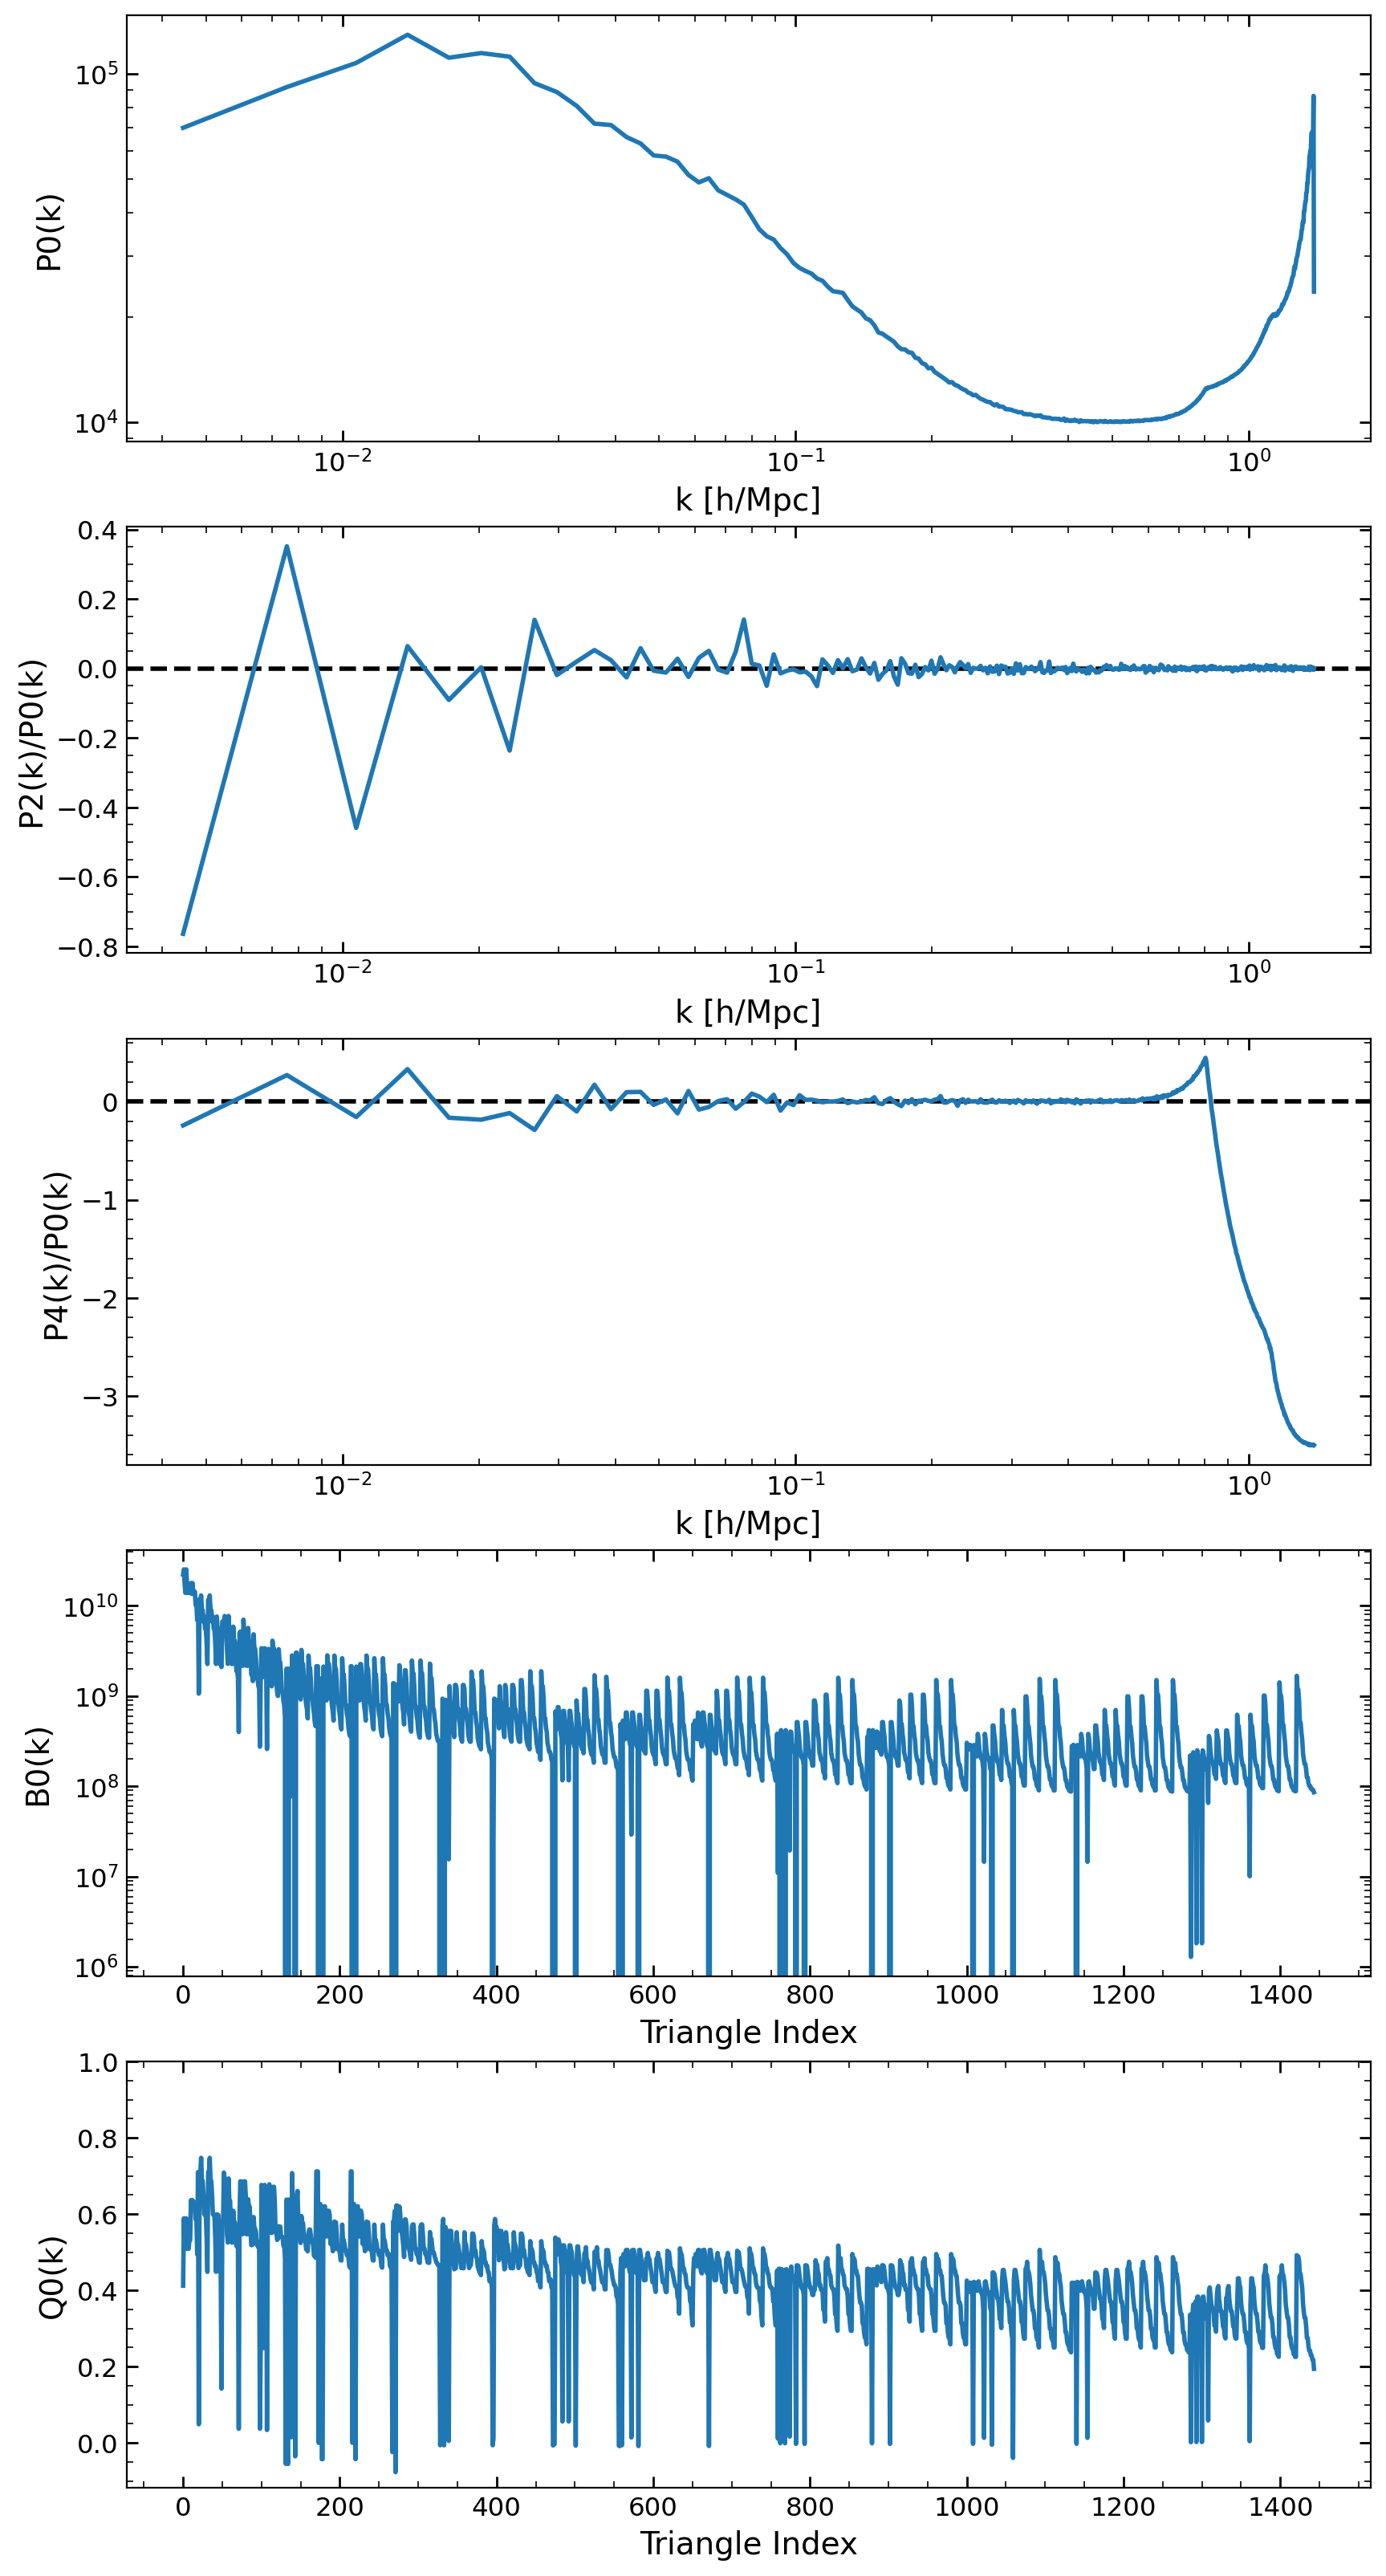

In [12]:
f, axs = plt.subplots(5, 1, figsize=(10, 20))

ax = axs[0]
ax.loglog(out['Pk_k3D'], out['Pk'][:, 0])
ax.set(xlabel='k [h/Mpc]', ylabel='P0(k)')

ax = axs[1]
ax.axhline(0, color='k', ls='--')
ax.semilogx(out['Pk_k3D'], out['Pk'][:, 1]/out['Pk'][:, 0])
ax.set(xlabel='k [h/Mpc]', ylabel='P2(k)/P0(k)')

ax = axs[2]
ax.axhline(0, color='k', ls='--')
ax.semilogx(out['Pk_k3D'], out['Pk'][:, 2]/out['Pk'][:, 0])
ax.set(xlabel='k [h/Mpc]', ylabel='P4(k)/P0(k)')

ax = axs[3]
ax.semilogy(out['Bk'][0])
ax.set(xlabel='Triangle Index', ylabel='B0(k)')

ax = axs[4]
ax.plot(out['Qk'][0])
ax.set(xlabel='Triangle Index', ylabel='Q0(k)')
ax.set_ylim(None, 1)